<a href="https://colab.research.google.com/github/Joshua-Lemus/machine_learning/blob/master/Proyecto_ML_ordenado.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Load packages**

In [8]:
# Numerical python and friends
import numpy as np
import pandas as pd
import seaborn as sb
import math
import matplotlib.pyplot as plt

# Machine learning packages
import category_encoders as ce # For encoding xd
from sklearn.preprocessing import LabelEncoder #
from sklearn.utils import check_random_state #For generating random permutations (?)
from sklearn.model_selection import train_test_split #
from sklearn import linear_model, metrics #
from sklearn.metrics import accuracy_score #
# For neural networks
from sklearn.neural_network import MLPClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import ParameterGrid
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder

# Misc packages
from datetime import datetime # Modulo que permite trabajar con fechas

In [9]:
random_seed = 0

# **Load, clean and encode data**

## Load data

In [10]:
# Load the data and some data visualization
df = pd.read_csv("SB11_20221.csv")
#print("Column values (before cleaning data):\n")
# for column in df.columns:
#   print(column, ':', set(df[column]))

#df.head()

## Clean data

In [11]:
# Cleaning data
# clean_df will contain the "clean" data
# Rename columns
clean_df = df.rename(columns={'Unnamed: 0': 'Code',
                          'ESTU_GENERO': 'Sex',
                          'ESTU_FECHANACIMIENTO': 'Birthdate',
                          'ESTU_TIENEETNIA': 'Ethnics',
                          'ESTU_DEPTO_RESIDE': 'Department',
                          'FAMI_ESTRATOVIVIENDA': 'Stratum',
                          'FAMI_EDUCACIONPADRE': 'FatherEduaction',
                          'FAMI_EDUCACIONMADRE': 'MotherEduaction',
                          'FAMI_TIENEINTERNET': 'HasInternet',
                          'FAMI_TIENECOMPUTADOR': 'HasComputer',
                          'COLE_NATURALEZA': 'SchoolType',
                          'COLE_AREA_UBICACION': 'SchoolPlace',
                          'COLE_JORNADA': 'SchoolShift',
                          'PUNT_GLOBAL': 'Score',
                          'ESTU_GENERACION-E': 'ScholarshipType'},
                         inplace=False)

# Remove nan values
#print(">>>>> Null entries per column (to be dropped)")
#print(df.isnull().sum())
clean_df = clean_df.dropna(axis='index', how='any')
percentage_removed = (len(df.index) - len(clean_df.index))/len(df.index)*100
print(f'\n>>>>> Removed {percentage_removed}% of rows for having nan data\n')

# Purge data by age
# strptime es un método que permite convertir un string a fecha de acuerdo a un formato
def edad(x):
    birth = datetime.strptime(x, '%d/%m/%Y') # Fecha nacimiento
    prueba = datetime.strptime('09/08/2020', '%d/%m/%Y') #Fecha presentación examen
    return prueba.year - birth.year # Edad el día de presentación del examen
clean_df['Age'] = clean_df['Birthdate'].apply(lambda x: edad(x))
# Creamos una copia cleand_df2, eliminamos edades menores a 14 y superiores a 81
pre_purge_length=len(clean_df)
clean_df = clean_df.loc[(clean_df['Age'] >= 14) & (clean_df['Age']<81)]
post_purge_length=len(clean_df)
age_removed = (post_purge_length-post_purge_length)#/pre_purge_length*100
print(f'\n>>>>> Further removed {age_removed} lines for having nonsensical age\n')

# Visualize the clean data
#clean_df.head()


>>>>> Removed 6.001544952165904% of rows for having nan data


>>>>> Further removed 0 lines for having nonsensical age



## *Encode categorical features*

In [12]:
# Encode categorical data
# Variables to encode
Vars = ['Sex', 'Department', 'Stratum', 'MotherEduaction', 'HasInternet', 'HasComputer', 'SchoolType', 'SchoolPlace', 'SchoolShift']
# The encoder we'll use
ce_be = ce.BinaryEncoder(cols=Vars)



# transform the data
data_binary = ce_be.fit_transform(clean_df)
# Add a column of ones (for learning a bias)
data_binary['ones'] = 1

# Visualize data
data_binary.head()

Code  Sex_0  Sex_1   Birthdate Ethnics  Department_0  Department_1  \
0  453241      0      1  27/04/2002      No             0             0   
1  387781      0      1  19/05/2005      Si             0             0   
2   77011      1      0  07/08/2002      Si             0             0   
3  135370      0      1  03/10/2001      Si             0             0   
4   31081      0      1  21/08/2002      No             0             0   

   Department_2  Department_3  Department_4  ...  SchoolType_1  SchoolPlace_0  \
0             0             0             0  ...             1              0   
1             0             0             1  ...             1              0   
2             0             0             1  ...             1              0   
3             0             1             0  ...             1              0   
4             0             1             0  ...             1              0   

   SchoolPlace_1  SchoolShift_0 SchoolShift_1  SchoolShift_2  Score  \
0              1              0             0              1    267   
1              1              0             0              1    282   
2              1              0             0              1    226   
3              1              0             0              1    237   
4              1              0             0              1    229   

            ScholarshipType  Age  ones  
0                        NO   18     1  
1                        NO   15     1  
2  GENERACION E - GRATUIDAD   18     1  
3                        NO   19     1  
4                        NO   18     1  

[5 rows x 34 columns]

# **The actual Machine learning stuff**

## Separate training and test data

In [13]:
# Separate features (X) and labels (Y)
# The variables to consider
BinaryVars = ['ones', 'Sex_0', 'Sex_1', 'Department_0', 'Department_1', 'Department_2', 'Department_3', 'Department_4', 'Department_5',
              'Stratum_0', 'Stratum_1', 'Stratum_2', 'MotherEduaction_0', 'MotherEduaction_1', 'MotherEduaction_2', 'MotherEduaction_3',
              'HasInternet_0', 'HasInternet_1', 'HasComputer_0', 'HasComputer_1', 'SchoolType_0', 'SchoolType_1',
              'SchoolPlace_0', 'SchoolPlace_1', 'SchoolShift_0', 'SchoolShift_1', 'SchoolShift_2']
X_data = data_binary[BinaryVars]
Y_data = data_binary['Score']
# Normalize score
Y_data = Y_data/max(Y_data)

# Shuffle data
random_state = check_random_state(random_seed)
permutation = random_state.permutation(len(data_binary))
X = X_data.iloc[permutation]
Y = Y_data.iloc[permutation]
# Check no error is made in the shuffling
if len(X) != len(data_binary):
  print("data shuffle is different than data length")

# Define size for training and test
train_size = math.floor(len(data_binary)*0.9)
test_size = len(data_binary)-train_size
# Separate training and test data
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,train_size=train_size,test_size=test_size)

# Visualize training data features
X_train.head()

ones  Sex_0  Sex_1  Department_0  Department_1  Department_2  \
43715     1      0      1             0             0             0   
39514     1      1      0             0             0             0   
89933     1      0      1             0             0             0   
80981     1      0      1             0             0             0   
85933     1      0      1             0             0             0   

       Department_3  Department_4  Department_5  Stratum_0  ...  \
43715             0             1             1          1  ...   
39514             1             0             0          0  ...   
89933             1             1             1          0  ...   
80981             1             0             0          1  ...   
85933             0             1             1          0  ...   

       HasInternet_1  HasComputer_0  HasComputer_1  SchoolType_0  \
43715              1              0              1             1   
39514              1              1              0             0   
89933              0              1              0             0   
80981              1              0              1             1   
85933              1              1              0             0   

       SchoolType_1  SchoolPlace_0  SchoolPlace_1  SchoolShift_0  \
43715             0              0              1              0   
39514             1              0              1              1   
89933             1              1              0              0   
80981             0              0              1              0   
85933             1              0              1              0   

       SchoolShift_1  SchoolShift_2  
43715              0              1  
39514              0              1  
89933              1              1  
80981              1              1  
85933              0              1  

[5 rows x 27 columns]

## Linear regression

In [14]:
# Functions for the linear optimization

def LinearOptimization(X, Y, print_theta=False, regularization='Linear', lam=1.0):
  ''' Returns a fitted linear regression model
  (dtype: sklearn.linear_model._base.LinearRegression)'''
  # Define a regression model
  if regularization=='Linear':
    reg = linear_model.LinearRegression()
  elif regularization=='Ridge':
    reg = linear_model.Ridge(lam)
  elif regularization=='LASSO':
    reg = linear_model.Lasso(lam)
  else:
    raise ValueError('Regularizacion no valida, valores validos: "Linear", "Ridge" o "LASSO"')

  # Fit the data
  reg.fit(X, Y)

  # Print the obtained parameters
  if print_theta:
    print('Coefficients (theta): ', reg.coef_)

  # Return the model
  return reg

def Test_error(Xtest, Ytest, reg, print_error=False):
  # Evaluate the model on our test data
  score = reg.score(Xtest, Ytest)

  return score


In [15]:
# Do the regularization
#-------------------------------------------------------------------------------
#regularizationtype='Ridge'
# Can be: 'Linear': no regularization
#         'Ridge':  L2 regularization
#         'LASSO':  L1 regularization

all_results = {'Regularization':[], 'Ein': [], 'lambda': [], 'Eout': []}

for regularizationtype in ['Linear', 'Ridge', 'LASSO']:
    ### Train using the training data
    for lam in np.linspace(0.1,10, 10):
        all_results['Regularization'].append(regularizationtype)

        print(f'Using lambda = {lam}')
        all_results['lambda'].append(lam)

        # Run optimization
        opt = LinearOptimization(X_train, Y_train, print_theta=False, regularization=regularizationtype, lam=lam)
        
        # Estimate in-sample accuracy
        Ein  = Test_error(X_train, Y_train, opt, print_error=False)
        print("in-sample R^2: ", Ein)
        all_results['Ein'].append(Ein)

        # Estimate out-sample accuracy
        Eout = Test_error(X_test, Y_test, opt, print_error=False)
        print("out-sample R^2: ", Eout)
        all_results['Eout'].append(Eout)


Using lambda = 0.1
in-sample R^2:  0.2212667631180435
out-sample R^2:  0.21317919535270002
Using lambda = 1.2000000000000002
in-sample R^2:  0.2212667631180435
out-sample R^2:  0.21317919535270002
Using lambda = 2.3000000000000003
in-sample R^2:  0.2212667631180435
out-sample R^2:  0.21317919535270002
Using lambda = 3.4000000000000004
in-sample R^2:  0.2212667631180435
out-sample R^2:  0.21317919535270002
Using lambda = 4.5
in-sample R^2:  0.2212667631180435
out-sample R^2:  0.21317919535270002
Using lambda = 5.6
in-sample R^2:  0.2212667631180435
out-sample R^2:  0.21317919535270002
Using lambda = 6.7
in-sample R^2:  0.2212667631180435
out-sample R^2:  0.21317919535270002
Using lambda = 7.800000000000001
in-sample R^2:  0.2212667631180435
out-sample R^2:  0.21317919535270002
Using lambda = 8.9
in-sample R^2:  0.2212667631180435
out-sample R^2:  0.21317919535270002
Using lambda = 10.0
in-sample R^2:  0.2212667631180435
out-sample R^2:  0.21317919535270002
Using lambda = 0.1
in-sample R

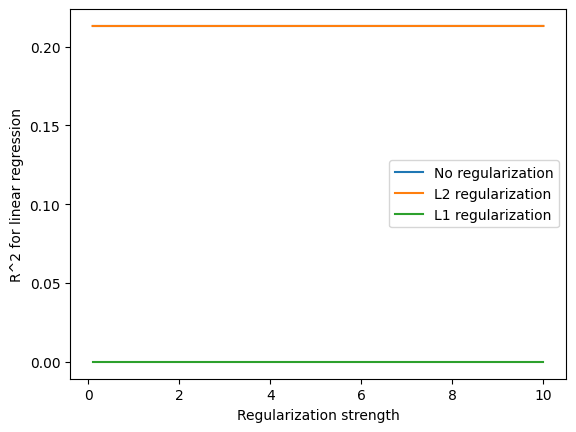

In [16]:
results_df = pd.DataFrame.from_dict(all_results)

linear_results=results_df.loc[results_df['Regularization']=='Linear']
ridge_results=results_df.loc[results_df['Regularization']=='Ridge']
lasso_results=results_df.loc[results_df['Regularization']=='LASSO']

plt.plot(linear_results['lambda'], linear_results['Eout'],label='No regularization')
plt.plot(ridge_results['lambda'], ridge_results['Eout'], label='L2 regularization')
plt.plot(lasso_results['lambda'], lasso_results['Eout'], label='L1 regularization')
plt.xlabel('Regularization strength')
plt.ylabel('R^2 for linear regression')
plt.legend(loc='best')


In [20]:
# Save only the best result
best_result=results_df.loc[results_df['Eout'].idxmax()]
best_result
#best_result['Regularization']

Regularization      Linear
Ein               0.221267
lambda                 0.1
Eout              0.213179
Name: 0, dtype: object

In [ ]:
with open("linear_results.csv", "w") as f:
  print(",Ein,Eout,alpha,momentum", file=f)
  print(f"{best_result['Regularization']},{best_result['Ein']},{best_result['Eout']},{best_result['lambda']},0", file=f)

## Softmax classification

### *Categorize labels*

In [22]:
# Categorize data
score_limits = [0, 150/500, 270/500, 359/500, 501/500]
score_labels = [0, 1, 2, 3]

Y_train_categorized = pd.cut(Y_train, bins=score_limits, labels=score_labels, right=False)
Y_test_categorized = pd.cut(Y_test, bins=score_limits, labels=score_labels, right=False)

# plt.hist(Y_train_categorized)
# plt.title('Category histogram')
# plt.xlabel('Category')
# plt.ylabel('Frequency')

In [ ]:
#Check we have no nan values in Y
if Y_test_categorized.isnull().sum()+Y_train_categorized.isnull().sum() == 0:
  print("No nan values in Y")
else:
  print("Careful! Nan values in Y")

#Check we have no nan values in X
ok=True
for i in (X_test.isnull().sum()+X_train.isnull().sum()):
  if i != 0:
    ok=False
if ok:
  print("No nan values in X")
else:
  print("Careful! Nan values in X")

No nan values in Y
No nan values in X


## Train the model

In [ ]:
# Initialize weights randomly
num_features = X_train.shape[1]                        # Number of features
num_classes = len(Y_train_categorized.cat.categories)  # Number of classes
weights = np.random.randn(num_features, num_classes)   # Initialize randomly the weights matrix

# Convert data to np ndarray for simplicity
X_train_np = X_train.to_numpy()
X_test_np = X_test.to_numpy()
Y_train_np = Y_train_categorized.to_numpy()
Y_test_np = Y_test_categorized.to_numpy()

# Training parameters
learning_rate = 1e-5                                        # learning rate
num_epochs = 1000                                           # max number of epochs
minibatch_size = 800                                        # minibatch size
num_batches = math.floor(len(Y_train_np)/minibatch_size)    # number of minibatches
tol=1e-5                                                    # Stop if |w(t+1)-w(t)| < tol
use_momentum=False                                           # Whether to use momentum or not
momentum=0.2                                                # momentum strength

# Initialize v
v=0
# Container for the errors
errors=[]
# Training loop
for epoch in range(num_epochs):
  # Separate in minibatches
  for k in range(num_batches):
    random_state = check_random_state(random_seed)
    permut = random_state.permutation(minibatch_size)    # Shuffle the data
    X_k = X_train_np[permut]                             # Select X data
    Y_k = Y_train_np[permut]                             # Select Y data

    # Compute logits (linear combinations)
    logits = X_k.dot(weights)                           # Preactivators (w \cdot x)

    # Apply softmax function to logits
    exp_logits = np.exp(1.0*logits)                     # e^{w \cdot x}

    softmax_probs = exp_logits / np.sum(exp_logits, axis=1, keepdims=True) # Post-activators ( e^{w x}/(\sum_w e^{w x}) )

    # Compute gradient of cross-entropy loss with respect to weights
    gradient = X_k.T.dot(softmax_probs - np.eye(num_classes)[Y_k])         # Gradient

    if use_momentum:
      v = learning_rate*gradient + momentum*v              # When using momentum, v(t+1) = lr*grad + m*v(t)
    else:
      v = learning_rate*gradient                           # When not using momentum, v(t+1) = lr*grad

    # Update weights
    new_weights = weights - v                              # Gradient descent: w(t+1) = w(t)-v
    # Check if convergence criterion is met:
    max_error = np.max(abs(new_weights-weights))           # max(\Delta(w))
    if max_error < tol:                                    # If  max(\Delta(w)) < tol
      break                                                # Then we're not learning anymore
      print('Solution converged')
    weights=new_weights                                    # Update weights

  if (epoch%100 == 0):                                     # Verbose option
    print(f'Finished epoch {epoch}')

  errors.append(max_error)                                 # Save errors

# Testing predictions
test_logits = X_test_np.dot(weights)                       # e^(w x)
test_softmax_probs = np.exp(test_logits) / np.sum(np.exp(test_logits), axis=1, keepdims=True) # sigma_i(w x) = e^(wij*xj)/sum_i(e^{wij*xj})
y_pred = np.argmax(test_softmax_probs, axis=1)             # Pick the class with higher probability
# Calculate accuracy
accuracy = accuracy_score(Y_test_np, y_pred)               # Accuracy = #correct/N_test
print(f"Out-sample accuracy: {accuracy:.2f}")

# Training predictions
train_logits = X_train_np.dot(weights)                     # And the same for training dataset...
train_softmax_probs = np.exp(train_logits) / np.sum(np.exp(train_logits), axis=1, keepdims=True)
ytrain_pred = np.argmax(train_softmax_probs, axis=1)
# Calculate accuracy
Ein = accuracy_score(Y_train_np, ytrain_pred)
print(f"In-sample accuracy: {Ein:.2f}")

Finished epoch 0
Finished epoch 100
Finished epoch 200
Finished epoch 300
Finished epoch 400
Finished epoch 500
Finished epoch 600
Finished epoch 700
Finished epoch 800
Finished epoch 900
Accuracy: 0.69
In-sample accuracy: 0.69


In [ ]:
with open('perceptron_results.csv','w') as f:
  f.write(',Ein,Eout,alpha,momentum\n')
  f.write(f'0,{Ein},{accuracy},0.0,{momentum}')

Max variance of the weights:9.999779842978507e-06
Max weight (if big, consider normalization): 2.4997846313394816


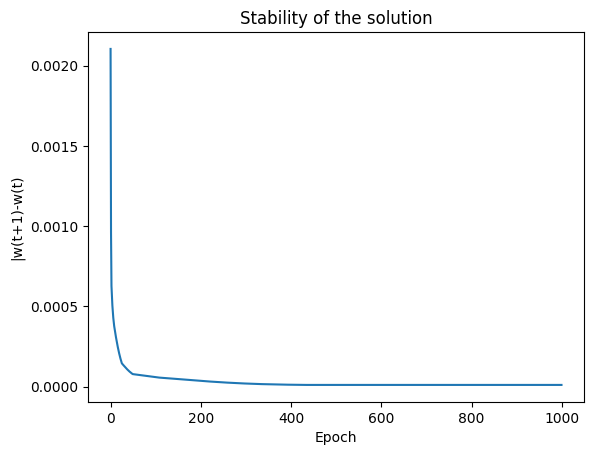

In [ ]:
plt.plot(errors)
plt.xlabel('Epoch')
plt.ylabel('|w(t+1)-w(t)')
plt.title('Stability of the solution')
print(f"Max variance of the weights:{errors[-1]}")
print(f'Max weight (if big, consider normalization): {np.max(weights)}')